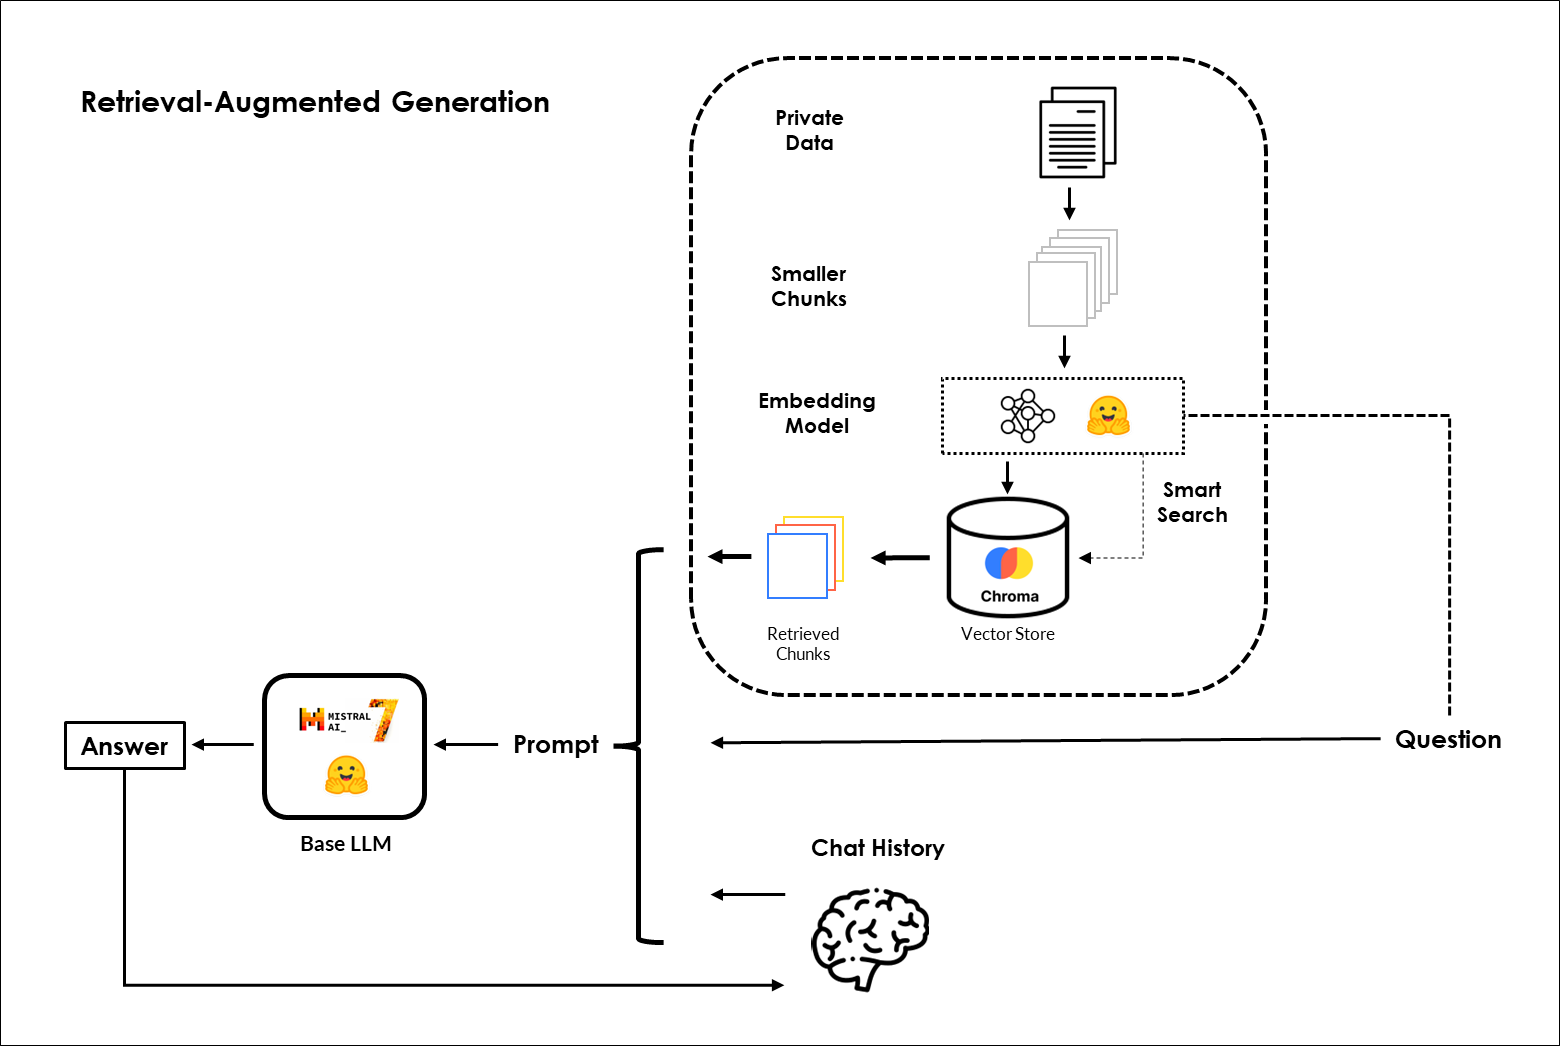

In [2]:
!pip install gradio --quiet
!pip install xformer --quiet
!pip install chromadb --quiet
!pip install langchain --quiet
!pip install accelerate --quiet
!pip install transformers --quiet
!pip install bitsandbytes --quiet
!pip install unstructured --quiet
!pip install sentence-transformers --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.7/16.7 MB 48.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.0/92.0 kB 13.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 305.2/305.2 kB 15.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.9/75.9 kB 5.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.8/139.8 kB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 381.9/381.9 kB 27.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.7/45.7 kB 3.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.5/7.5 MB 51.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.6/60.6 kB 7.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.9/129.9 kB 15.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 38.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 6.8 MB/s 

#### Imports

In [3]:
import torch
import gradio as gr

from textwrap import fill
from IPython.display import Markdown, display

from langchain.prompts.chat import (
    ChatPromptTemplate,
    HumanMessagePromptTemplate,
    SystemMessagePromptTemplate,
    )

from langchain import PromptTemplate
from langchain import HuggingFacePipeline

from langchain.vectorstores import Chroma
from langchain.schema import AIMessage, HumanMessage
from langchain.memory import ConversationBufferMemory
from langchain.embeddings import HuggingFaceEmbeddings
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.document_loaders import UnstructuredMarkdownLoader, UnstructuredURLLoader
from langchain.chains import LLMChain, SimpleSequentialChain, RetrievalQA, ConversationalRetrievalChain

from transformers import BitsAndBytesConfig, AutoModelForCausalLM, AutoTokenizer, GenerationConfig, pipeline

import warnings
warnings.filterwarnings('ignore')

In [4]:
MODEL_NAME = "mistralai/Mistral-7B-Instruct-v0.1"

quantization_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_compute_dtype=torch.float16,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_use_double_quant=True,
)

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME, use_fast=True)
tokenizer.pad_token = tokenizer.eos_token

model = AutoModelForCausalLM.from_pretrained(
    MODEL_NAME, torch_dtype=torch.float16,
    trust_remote_code=True,
    device_map="auto",
    quantization_config=quantization_config
)

generation_config = GenerationConfig.from_pretrained(MODEL_NAME)
generation_config.max_new_tokens = 1024
generation_config.temperature = 0.0001
generation_config.top_p = 0.95
generation_config.do_sample = True
generation_config.repetition_penalty = 1.15

pipeline = pipeline(
    "text-generation",
    model=model,
    tokenizer=tokenizer,
    return_full_text=True,
    generation_config=generation_config,
)

tokenizer_config.json:   0%|          | 0.00/1.47k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/493k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.80M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/72.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/25.1k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/9.94G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/4.54G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

In [5]:
llm = HuggingFacePipeline(
    pipeline=pipeline,
    )

In [6]:
embeddings = HuggingFaceEmbeddings(
    model_name="thenlper/gte-large",
    model_kwargs={"device": "cuda"},
    encode_kwargs={"normalize_embeddings": True},
)

.gitattributes:   0%|          | 0.00/1.52k [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/191 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/67.9k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/619 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/670M [00:00<?, ?B/s]

onnx/config.json:   0%|          | 0.00/632 [00:00<?, ?B/s]

model.onnx:   0%|          | 0.00/1.34G [00:00<?, ?B/s]

onnx/special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

onnx/tokenizer.json:   0%|          | 0.00/712k [00:00<?, ?B/s]

onnx/tokenizer_config.json:   0%|          | 0.00/342 [00:00<?, ?B/s]

onnx/vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/670M [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/57.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/712k [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/342 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

modules.json:   0%|          | 0.00/385 [00:00<?, ?B/s]

#### Prompt Template

In [ ]:
template = """
[INST] <>
Act as a Machine Learning engineer who is teaching high school students.
<>

{text} [/INST]
"""

prompt = PromptTemplate(
    input_variables=["text"],
    template=template,
)

#### Data Loading

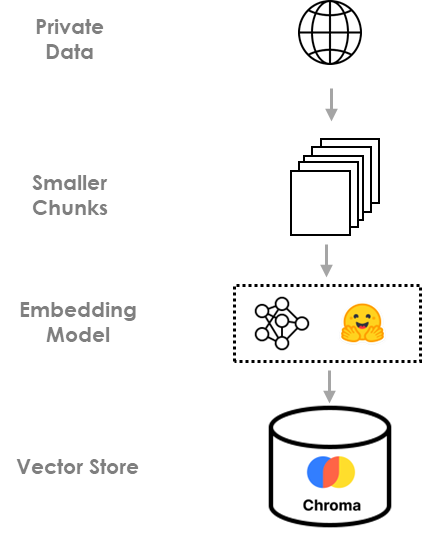

In [10]:
urls = [
    "https://gnyan.ai/",
    "https://www.personoids.com/2023/06/06/promptware.html"
]

loader = UnstructuredURLLoader(urls=urls)
documents = loader.load()

len(documents)

2

In [11]:
text_splitter = RecursiveCharacterTextSplitter(chunk_size=1024, chunk_overlap=64)
texts_chunks = text_splitter.split_documents(documents)

len(texts_chunks)

7

#### Data Ingestion

In [12]:
db = Chroma.from_documents(texts_chunks, embeddings, persist_directory="db")

In [14]:
template = """
[INST] <>
Act as an GNYAN.AI marketing manager expert. Use the following information to answer the question at the end.
<>

{context}

{question} [/INST]
"""

prompt = PromptTemplate(template=template, input_variables=["context", "question"])

qa_chain = RetrievalQA.from_chain_type(
    llm=llm,
    chain_type="stuff",
    retriever=db.as_retriever(search_kwargs={"k": 2}),
    return_source_documents=True,
    chain_type_kwargs={"prompt": prompt},
)

#### Querying

In [15]:
query = "What is Promptware?"
result_ = qa_chain(
    query
)
result = result_["result"].strip()


display(Markdown(f"<b>{query}</b>"))
display(Markdown(f"<p>{result}</p>"))

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


<b>What is Promptware?</b>

<p>Promptware is a new approach in engineering that uses AI models to create products and businesses. It involves providing these models with well-crafted prompts to generate novel solutions, streamline development, and even establish new organizations. The process combines multiple prompts to explore different aspects of a problem or business, resulting in highly efficient and effective output.</p>

In [16]:
query = "Why GNYAN.AI has created Promptware?"
result_ = qa_chain(
    query
)
result = result_["result"].strip()


display(Markdown(f"<b>{query}</b>"))
display(Markdown(f"<p>{result}</p>"))

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


<b>Why GNYAN.AI has created Promptware?</b>

<p>GNYAN.AI has created Promptware because it recognizes the potential of AI to revolutionize the way we approach engineering and product development. With Promptware, engineers can leverage AI models to generate innovative solutions, collaborate more effectively, streamline development processes, and reduce costs. By combining multiple prompts to explore different aspects of a problem or business, Promptware enables rapid iteration and adaptation, making it ideal for today's fast-paced, ever-changing marketplace.</p>

In [17]:
result_["source_documents"]

[Document(page_content='With this definition in mind, let’s delve deeper into the world of Promptware and explore its potential benefits and applications.\n\nWhat is Promptware?\n\nPromptware refers to a new approach in engineering that leverages AI models to create products and businesses. By providing these models with well-crafted prompts, we can produce novel solutions, streamline development, and even establish new organizations. This process involves the combination of multiple prompts to explore different aspects of a problem or a business, resulting in highly efficient and effective output.\n\nBenefits of Promptware:\n\nAccelerated Innovation: Promptware enables rapid innovation by harnessing the power of AI models. By providing well-crafted prompts, engineers can quickly generate new ideas and solutions, reducing the time and resources required for traditional brainstorming and prototyping.', metadata={'source': 'https://www.personoids.com/2023/06/06/promptware.html'}),
 Docum

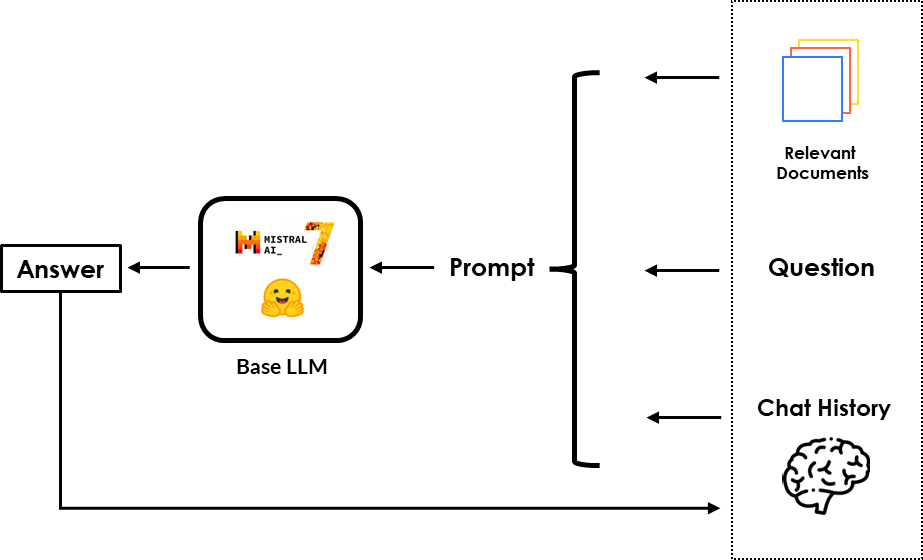

In [31]:
custom_template = """You are an GNAYAN.AI Marketing Manager AI Assistant. Given the
following conversation and a follow up question, rephrase the follow up question
to be a standalone question. At the end of standalone question add this
'Answer the question in English language.' If you do not know the answer reply with 'I am sorry, I dont have enough information'.
Chat History:
{chat_history}
Follow Up Input: {question}
Standalone question:
"""

CUSTOM_QUESTION_PROMPT = PromptTemplate.from_template(custom_template)

memory = ConversationBufferMemory(memory_key="chat_history", return_messages=True)

qa_chain = ConversationalRetrievalChain.from_llm(
    llm=llm,
    retriever=db.as_retriever(search_kwargs={"k": 2}),
    memory=memory,
    condense_question_prompt=CUSTOM_QUESTION_PROMPT,
)

In [32]:
query = "Who you are?"
result_ = qa_chain({"question": query})
result = result_["answer"].strip()

display(Markdown(f"<b>{query}</b>"))
display(Markdown(f"<p>{result}</p>"))

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


<b>Who you are?</b>

<p>We are a team delivering mixed initiative enterprise outcomes for customers using AI and human capital.</p>

In [21]:
query = "What do you offer?"
result_ = qa_chain({"question": query})
result = result_["answer"].strip()

display(Markdown(f"<b>{query}</b>"))
display(Markdown(f"<p>{result}</p>"))

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


<b>What do you offer?</b>

<p>GNAYAN.AI offers mixed initiative enterprise promptware solutions that leverage generative AI and large foundation models to create rich multimedia content. They also provide flexible sourcing options such as engaging with customers in close pair-programming mode or delivering turnkey solutions. Additionally, they have a team of experts who are responsible for delivering enterprise outcomes for their clients.</p>

In [22]:
query = "What is Promptware?"

result_ = qa_chain({"question": query})
result = result_["answer"].strip()

display(Markdown(f"<b>{query}</b>"))
display(Markdown(f"<p>{result}</p>"))

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


<b>What is Promptware?</b>

<p>Promptware is a new approach in engineering that uses AI models to create products and businesses by providing them with well-crafted prompts. It offers accelerated innovation, enhanced collaboration, streamlined development, and cost-effectiveness.</p>

In [23]:
query = "Why it has been created?"

result_ = qa_chain({"question": query})
result = result_["answer"].strip()

display(Markdown(f"<b>{query}</b>"))
display(Markdown(f"<p>{result}</p>"))

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


<b>Why it has been created?</b>

<p>Promptware was created to address the challenges faced by traditional engineering methods, such as slow innovation, limited collaboration, and high costs. By leveraging AI models and well-crafted prompts, Promptware aims to accelerate innovation, enhance collaboration, streamline development, and reduce costs.</p>

In [24]:
memory.chat_memory.messages

[HumanMessage(content='Who you are?'),
 AIMessage(content=' We are a team delivering mixed initiative enterprise outcomes for customers using AI and human capital.'),
 HumanMessage(content='What do you do?'),
 AIMessage(content=" I don't have any information about your company."),
 HumanMessage(content='What do you offer?'),
 AIMessage(content=' GNAYAN.AI offers mixed initiative enterprise promptware solutions that leverage generative AI and large foundation models to create rich multimedia content. They also provide flexible sourcing options such as engaging with customers in close pair-programming mode or delivering turnkey solutions. Additionally, they have a team of experts who are responsible for delivering enterprise outcomes for their clients.'),
 HumanMessage(content='What is Promptware?'),
 AIMessage(content=' Promptware is a new approach in engineering that uses AI models to create products and businesses by providing them with well-crafted prompts. It offers accelerated inno

### **Gradio Chat UI**

In [25]:
def querying(query, history):
  memory = ConversationBufferMemory(memory_key="chat_history", return_messages=True)

  qa_chain = ConversationalRetrievalChain.from_llm(
      llm=llm,
      retriever=db.as_retriever(search_kwargs={"k": 2}),
      memory=memory,
      condense_question_prompt=CUSTOM_QUESTION_PROMPT,
  )

  result = qa_chain({"question": query})
  return result["answer"].strip()

In [27]:
iface = gr.ChatInterface(
    fn = querying,
    chatbot=gr.Chatbot(height=600),
    textbox=gr.Textbox(placeholder="What is Promptware?", container=False, scale=7),
    title="GnyaneeBot",
    theme="soft",
    examples=["Why GNYAN.AI has created Promptware?",
              "What is Promptware"],

    cache_examples=True,
    retry_btn = "Retry",
    undo_btn = "Undo",
    clear_btn = "Clear",
    submit_btn = "Submit"


    )

iface.launch(share=True)

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Caching examples at: '/content/gradio_cached_examples/16'
Caching example 1/2


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Caching example 2/2
Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Running on public URL: https://cfe4839cd1d3d8cb9d.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)
